0.학습 모듈 갖고오기

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import tensorflow as tf
from tensorflow.keras import layers, models

1. 드라이브 패턴 시뮬레이션 (1시간 주헤ㅐㅇ)

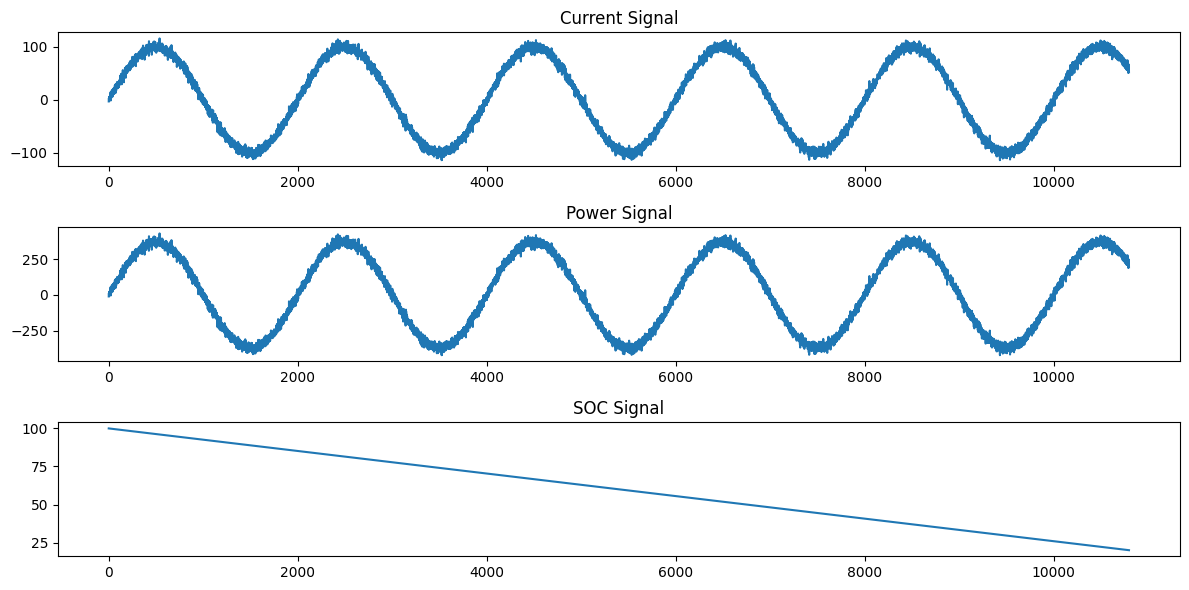

In [32]:
# 1. 드라이브 패턴 시뮬레이션 (3시간 주행으로 확장)
time = np.arange(0, 10800, 1)  # 3시간 동안 1초 간격
current_signal = 100 * np.sin(0.001 * np.pi * time) + np.random.normal(0, 5, len(time))
power_signal = current_signal * 3.7  # 가상 전압
soc_signal = np.linspace(100, 20, len(time))  # 단순 SOC 감소 가정

# 데이터 시각화
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(time, current_signal)
plt.title('Current Signal')
plt.subplot(3, 1, 2)
plt.plot(time, power_signal)
plt.title('Power Signal')
plt.subplot(3, 1, 3)
plt.plot(time, soc_signal)
plt.title('SOC Signal')
plt.tight_layout()
plt.show()

2. LSTM SOH 예측 모델(임시, 간단한 구조)

/Users/jdkwon/Desktop/ML 학습강의/Battery AI Test/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


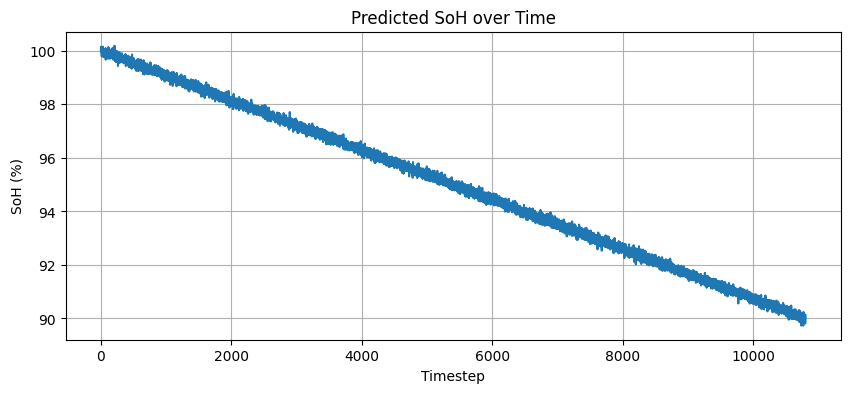

soh_pred length: 10800


In [33]:
# 2. LSTM SoH 예측 모델 (임시, 간단한 구조)
def create_dummy_lstm_model(input_shape):
    model = models.Sequential([
        layers.LSTM(64, input_shape=input_shape, return_sequences=False),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# 가상의 LSTM SoH 예측 모델 생성 및 더미 학습
X_dummy = np.stack([current_signal, power_signal, soc_signal], axis=1)
X_dummy = X_dummy.reshape((1, X_dummy.shape[0], X_dummy.shape[1]))
model = create_dummy_lstm_model((X_dummy.shape[1], X_dummy.shape[2]))
y_dummy = np.linspace(100, 90, X_dummy.shape[1])  # SoH가 3시간 동안 100% -> 90%로 감소 가정
model.fit(X_dummy, y_dummy.reshape(1, -1), epochs=5, verbose=0)

# 3. SoH 예측
soh_pred = model.predict(X_dummy)[0]

# 4. 예측하기에 데이터가 너무 무의미하니 가짜 데이터 입력
np.random.seed(42)
soh_pred = np.linspace(100, 90, 10800) + np.random.normal(0, 0.1, 10800)

# 데이터 시각화
plt.figure(figsize=(10, 4))
plt.plot(soh_pred)
plt.title('Predicted SoH over Time')
plt.xlabel('Timestep')
plt.ylabel('SoH (%)')
plt.grid()
plt.show()

print(f"soh_pred length: {len(soh_pred)}")

드라이브 패턴 최적 Cycle 길이 탐색

In [34]:
# 4. 최적 Cycle 길이 탐색
window_sizes = [30, 60, 90, 120]
best_score = -1
best_window = None
scores = []

def segment_signal(signal, window):
    return [signal[i:min(i+window, len(signal))] for i in range(0, len(signal), window)]

def extract_cycle_features(cycles):
    features = []
    for cycle in cycles:
        if len(cycle) < 2:
            continue  # 너무 짧은 Cycle은 건너뛰기
        delta_soh = cycle[0] - cycle[-1]
        slope = (cycle[-1] - cycle[0]) / len(cycle)
        std_dev = np.std(cycle)
        features.append([delta_soh, slope, std_dev])
    return np.array(features)

for window in window_sizes:
    cycles = segment_signal(soh_pred, window)
    if len(cycles) < 3:
        continue
    
    features = extract_cycle_features(cycles)
    if len(features) < 3:
        continue  # Feature가 3개 미만이면 군집화 불가

    if features.ndim == 1:
        features = features.reshape(-1, 1)

    n_clusters = min(3, len(features))  # 클러스터 수를 Feature 수 이하로 제한
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features)
    score = silhouette_score(features, labels)
    scores.append(score)

    if score > best_score:
        best_score = score
        best_window = window

if best_window is None:
    raise ValueError("❌ 최적 Cycle 길이를 찾지 못했습니다. 데이터 길이나 window_sizes를 다시 확인하세요.")

print(f"\n✅ 최적 Cycle 길이: {best_window}초 (Silhouette Score = {best_score:.4f})")

# 5. 최적 길이로 분할
final_cycles = segment_signal(soh_pred, best_window)
final_features = extract_cycle_features(final_cycles)



✅ 최적 Cycle 길이: 60초 (Silhouette Score = 0.5562)


6. 군집화하여 대표 Cycle 선택하기

In [35]:
# 6. 군집화
kmeans_final = KMeans(n_clusters=3, random_state=42)
final_labels = kmeans_final.fit_predict(final_features)

# 7. 군집별 대표 Cycle 선택
representative_cycles = []
for cluster_id in np.unique(final_labels):
    idxs = np.where(final_labels == cluster_id)[0]
    center = kmeans_final.cluster_centers_[cluster_id]
    rep_idx = idxs[np.argmin(np.linalg.norm(final_features[idxs] - center, axis=1))]
    representative_cycles.append(final_cycles[rep_idx])

# 8. 대표 Cycle 평균
average_cycle = np.mean(np.stack(representative_cycles), axis=0)

9. 결과 시각화하기

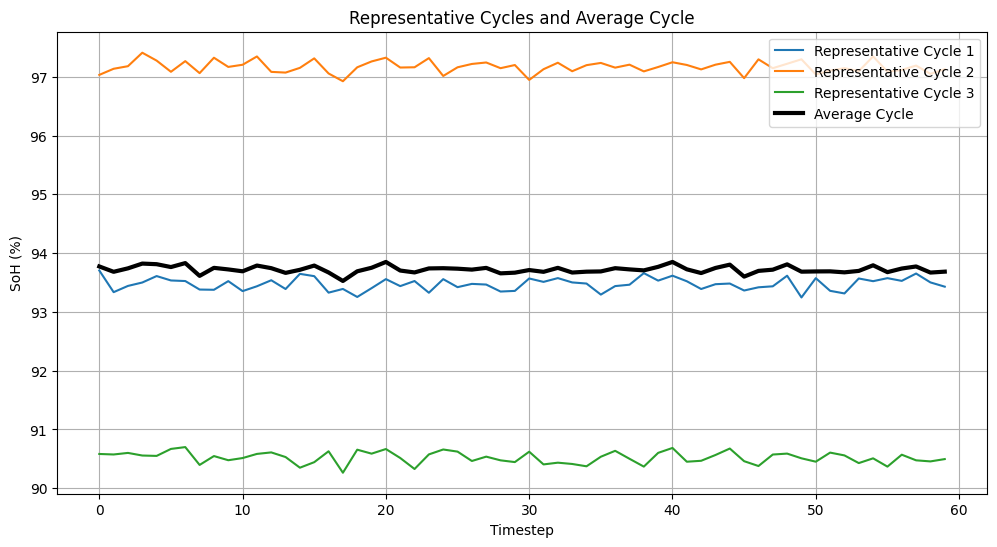

In [36]:
# 9. 중간단계 결과 시각화
plt.figure(figsize=(12, 6))
for i, cycle in enumerate(representative_cycles):
    plt.plot(cycle, label=f'Representative Cycle {i+1}')
plt.plot(average_cycle, label='Average Cycle', linewidth=3, color='black')
plt.xlabel('Timestep')
plt.ylabel('SoH (%)')
plt.title('Representative Cycles and Average Cycle')
plt.legend()
plt.grid()
plt.show()


9. 대표하는 Cycle 인덱스 가져오기

In [37]:
# ============================================
# 9. 대표 Cycle 인덱스 다시 제대로 가져오기
# ============================================

# 대표 Cycle 인덱스 (SOH 기반)
representative_idxs = []
for cluster_id in np.unique(final_labels):
    idxs = np.where(final_labels == cluster_id)[0]
    center = kmeans_final.cluster_centers_[cluster_id]
    rep_idx_within_cluster = idxs[np.argmin(np.linalg.norm(final_features[idxs] - center, axis=1))]
    representative_idxs.append(rep_idx_within_cluster)

# ============================================
# 10. 원본 드라이브 충방전 데이터 준비
# ============================================

# full_current_signal, full_power_signal, full_soc_signal, full_temp_signal
# (미리 준비되어 있어야 함)

# Cycle 단위 분할
def segment_full_signal(signal, window):
    return [signal[i:min(i+window, len(signal))] for i in range(0, len(signal), window)]

cycles_current = segment_full_signal(current_signal, best_window)
cycles_power = segment_full_signal(power_signal, best_window)
cycles_soc = segment_full_signal(soc_signal, best_window)

# ============================================
# 11. 대표 Cycle에 해당하는 충방전 패턴 추출
# ============================================

representative_profiles = []

for idx in representative_idxs:
    profile = pd.DataFrame({
        'Time (s)': np.arange(len(cycles_current[idx])),
        'Current (A)': cycles_current[idx],
        'Power (W)': cycles_power[idx],
        'SOC (%)': cycles_soc[idx],
    })
    representative_profiles.append(profile)

# ============================================
# 12. 대표 충방전 프로파일 평균 생성
# ============================================

# 가장 짧은 길이에 맞춰서 자르기
min_length = min(len(profile) for profile in representative_profiles)

trimmed_profiles = []
for profile in representative_profiles:
    trimmed_profiles.append(profile.iloc[:min_length])

# 평균 프로파일 생성
average_profile = pd.DataFrame()
average_profile['Time (s)'] = np.arange(min_length)
average_profile['Current (A)'] = np.mean([p['Current (A)'].values for p in trimmed_profiles], axis=0)
average_profile['Power (W)'] = np.mean([p['Power (W)'].values for p in trimmed_profiles], axis=0)
average_profile['SOC (%)'] = np.mean([p['SOC (%)'].values for p in trimmed_profiles], axis=0)

# ============================================
# 13. 최종 Cycle Profile 저장
# ============================================

average_profile.to_csv('final_drive_cycle_profile.csv', index=False)
print("✅ 최종 Drive Cycle Profile 저장 완료: final_drive_cycle_profile.csv")


✅ 최종 Drive Cycle Profile 저장 완료: final_drive_cycle_profile.csv


# ================================================
# 14. 사이클 주기성(Pseudo-periodic Cycle) 데이터의 변환
# ================================================      

✅ 최종 가공된 Cycle Profile 저장 완료: final_drive_cycle_profile_ready_for_test.csv


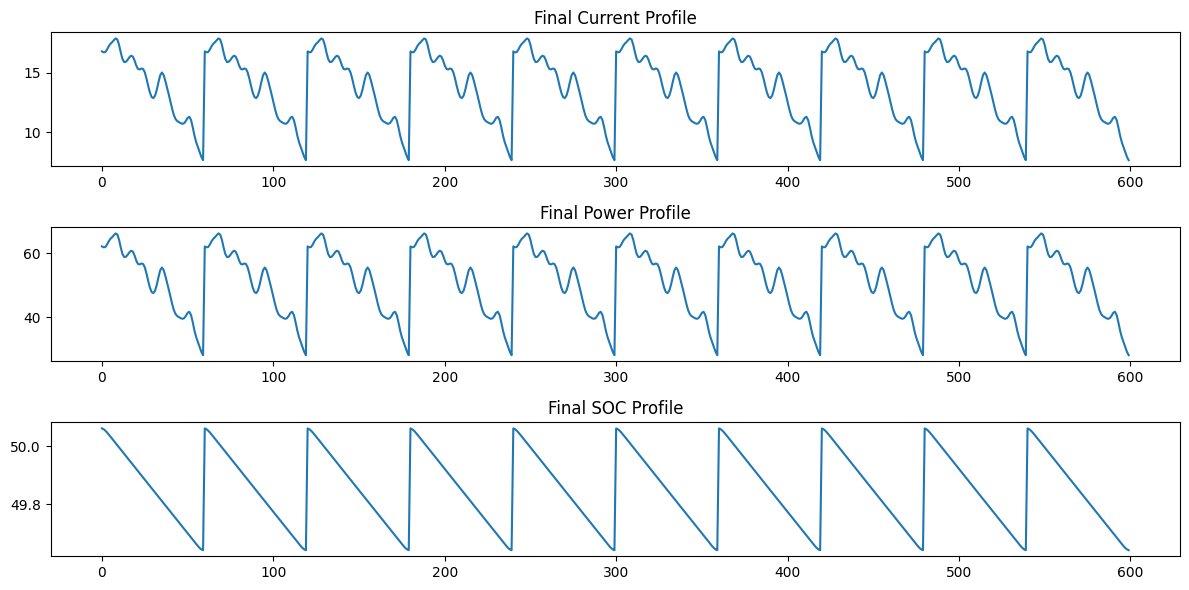

     Time (s)  Current (A)  Power (W)    SOC (%)
0           0    16.803784  62.174001  50.060845
1           1    16.727210  61.890678  50.058063
2           2    16.751942  61.982187  50.053081
3           3    16.967474  62.779653  50.046723
4           4    17.250602  63.827226  50.039685
..        ...          ...        ...        ...
595       595     9.146966  33.843774  49.662140
596       596     8.736372  32.324576  49.655102
597       597     8.331602  30.826929  49.648743
598       598     7.915545  29.287517  49.643761
599       599     7.633384  28.243520  49.640979

[600 rows x 4 columns]


In [38]:
from scipy.ndimage import gaussian_filter1d

# 1. 전류/전력 clipping (Peak 제한)
current_limit = 150  # A 예시
power_limit = 50000  # W 예시

average_profile['Current (A)'] = np.clip(average_profile['Current (A)'], -current_limit, current_limit)
average_profile['Power (W)'] = np.clip(average_profile['Power (W)'], -power_limit, power_limit)

# 2. SOC 범위 클리핑
soc_upper = 100
soc_lower = 20

average_profile['SOC (%)'] = np.clip(average_profile['SOC (%)'], soc_lower, soc_upper)

# 3. smoothing (자연스럽게 만들기)
average_profile['Current (A)'] = gaussian_filter1d(average_profile['Current (A)'], sigma=2)
average_profile['Power (W)'] = gaussian_filter1d(average_profile['Power (W)'], sigma=2)
average_profile['SOC (%)'] = gaussian_filter1d(average_profile['SOC (%)'], sigma=2)

# 4. 시간 리스케일 (필요시)
# average_profile['Time (s)'] = np.linspace(0, total_cycle_time, len(average_profile))

# 5. 최종 Cycle Block 반복 생성 (원하면)
repeat_factor = 10  # 10번 반복
repeated_profile = pd.concat([average_profile]*repeat_factor, ignore_index=True)

# 6. 최종 Profile 저장
repeated_profile.to_csv('final_drive_cycle_profile_ready_for_test.csv', index=False)
print("✅ 최종 가공된 Cycle Profile 저장 완료: final_drive_cycle_profile_ready_for_test.csv")

# 시간 축 재조정
repeated_profile['Time (s)'] = np.arange(len(repeated_profile))

# 데이터 시각화
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(repeated_profile['Time (s)'], repeated_profile['Current (A)'])
plt.title('Final Current Profile')
plt.subplot(3, 1, 2)
plt.plot(repeated_profile['Time (s)'], repeated_profile['Power (W)'])
plt.title('Final Power Profile')
plt.subplot(3, 1, 3)
plt.plot(repeated_profile['Time (s)'], repeated_profile['SOC (%)'])
plt.title('Final SOC Profile')
plt.tight_layout()
plt.show()

print(repeated_profile)


SHAP 분석

/var/folders/tj/pf95hf854s3f0gymm16_hv100000gn/T/ipykernel_34960/3820832157.py:56: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, feature_names=['Avg Current', 'Max Current', 'Avg Power', 'Max Power', 'SOC Drop'])


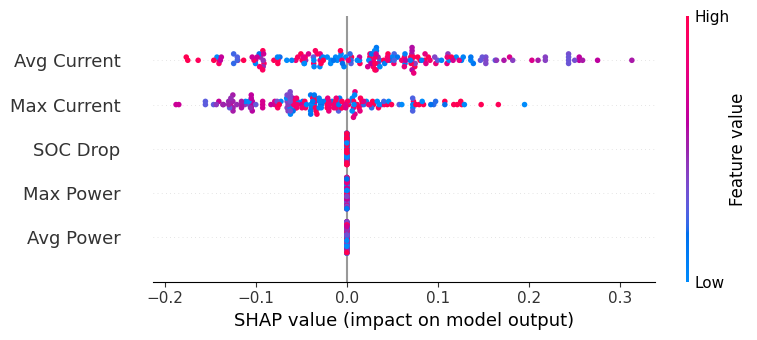


✅ Representative Cycle 117 SHAP 분석 결과


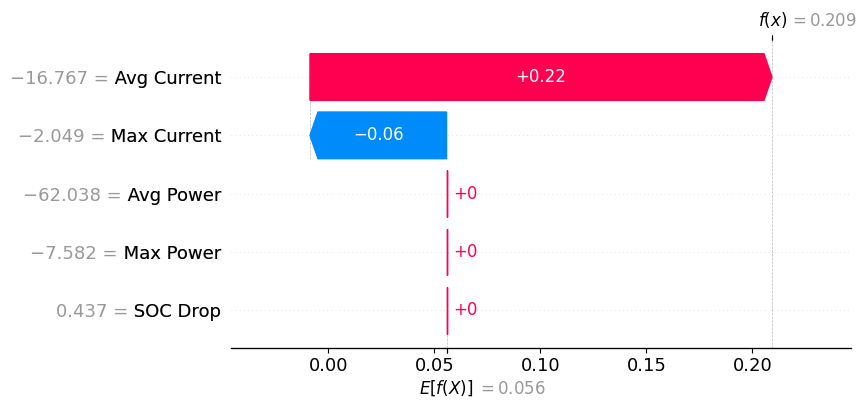


✅ Representative Cycle 50 SHAP 분석 결과


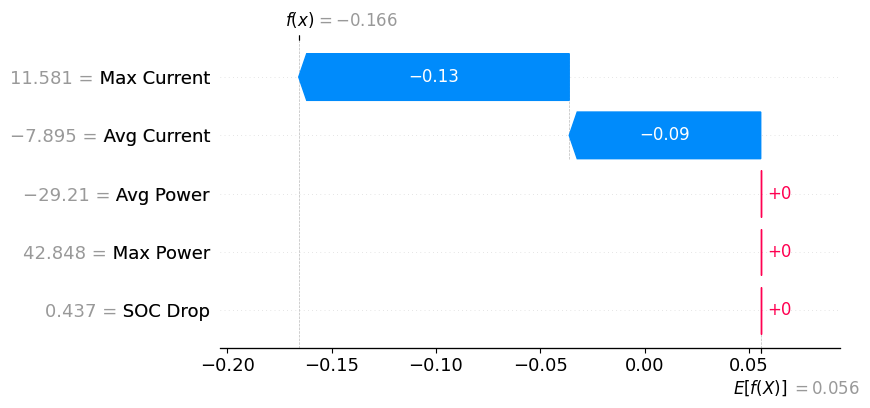


✅ Representative Cycle 170 SHAP 분석 결과


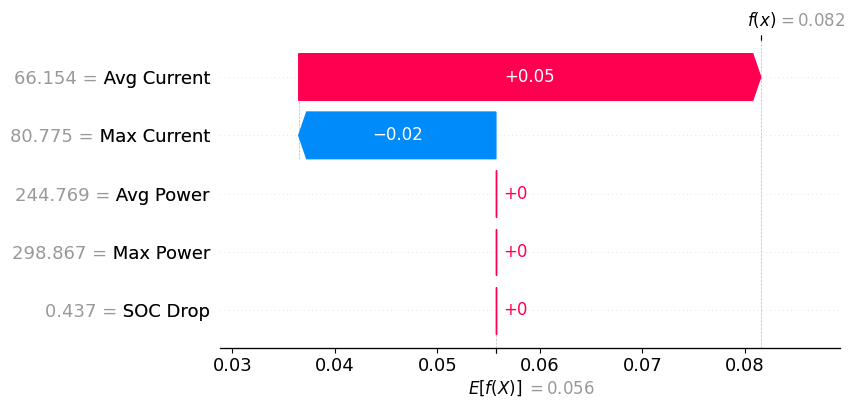

In [48]:
# ============================================
# 14. 대표 Cycle Feature로 열화 해석 준비
# ============================================

import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# (전제)
# cycles_current, cycles_power, cycles_soc, cycles_temp: 이미 window 단위로 분할된 상태
# representative_idxs: 대표 Cycle 인덱스 리스트

# 1. 대표 Cycle에 대해 Feature 추출
def extract_input_features(cycles_current, cycles_power, cycles_soc):
    features = []
    for curr, pwr, soc in zip(cycles_current, cycles_power, cycles_soc):
        mean_curr = np.mean(curr)
        max_curr = np.max(curr)
        mean_pwr = np.mean(pwr)
        max_pwr = np.max(pwr)
        delta_soc = soc[0] - soc[-1]
        features.append([mean_curr, max_curr, mean_pwr, max_pwr, delta_soc])
    return np.array(features)

# 모든 Cycle에 대해 Feature 추출
extracted_features = extract_input_features(cycles_current, cycles_power, cycles_soc)

# ΔSoH 계산 (Cycle 단위)
soh_start = soh_pred[::best_window]
soh_end = soh_pred[best_window::best_window]

# 먼저 안전하게 길이 맞추기
min_length = min(len(soh_start), len(soh_end))
soh_start = soh_start[:min_length]
soh_end = soh_end[:min_length]
soh_drops = soh_start - soh_end  # ΔSoH

# Feature와 y 모두 길이 통일
min_final_length = min(len(extracted_features), len(soh_drops))

feature_names = ['Avg Current', 'Max Current', 'Avg Power', 'Max Power', 'SOC Drop']
X = pd.DataFrame(extracted_features[:min_final_length], columns=feature_names)
y = soh_drops[:min_final_length]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(n_estimators=100, max_depth=4, random_state=42)
model.fit(X_train, y_train)

# 4. SHAP 해석
explainer = shap.Explainer(model)
shap_values = explainer(X)

# 전체 Cycle 기준 Summary plot
shap.summary_plot(shap_values, X, feature_names=['Avg Current', 'Max Current', 'Avg Power', 'Max Power', 'SOC Drop'])

# 5. 대표 Cycle별 SHAP Waterfall Plot
for idx in representative_idxs:
    print(f"\n✅ Representative Cycle {idx} SHAP 분석 결과")
    shap.plots.waterfall(shap_values[idx])


In [49]:
# 6. 대표 Cycle별 Top 2 Feature 추출

top_features_per_cycle = []

feature_names = ['Avg Current', 'Max Current', 'Avg Power', 'Max Power', 'SOC Drop']

for idx in representative_idxs:
    # SHAP 값 하나 가져오기
    shap_val = shap_values[idx].values  # SHAP 값 배열
    abs_shap = np.abs(shap_val)  # 절대값 취함 (영향도 크기 기준)

    # 상위 2개 Feature 인덱스 찾기
    top2_indices = np.argsort(abs_shap)[-2:][::-1]  # 내림차순 정렬
    
    # Feature 이름과 SHAP 값 같이 저장
    top_features = [(feature_names[i], shap_val[i]) for i in top2_indices]

    # 리스트에 저장
    top_features_per_cycle.append({
        'Representative Cycle Index': idx,
        'Top1 Feature': top_features[0][0],
        'Top1 SHAP Value': top_features[0][1],
        'Top2 Feature': top_features[1][0],
        'Top2 SHAP Value': top_features[1][1]
    })

# 7. 결과 출력
import pandas as pd

top_features_df = pd.DataFrame(top_features_per_cycle)
print("\n✅ 대표 Cycle별 SHAP Top1, Top2 Feature:")
display(top_features_df)

# 필요하면 CSV로 저장
top_features_df.to_csv('representative_cycle_top_features.csv', index=False)
print("\n✅ Top Features 저장 완료: representative_cycle_top_features.csv")



✅ 대표 Cycle별 SHAP Top1, Top2 Feature:


,Representative Cycle Index,Top1 Feature,Top1 SHAP Value,Top2 Feature,Top2 SHAP Value
0,117,Avg Current,0.217951,Max Current,-0.064439
1,50,Max Current,-0.129703,Avg Current,-0.091815
2,170,Avg Current,0.045069,Max Current,-0.019232



✅ Top Features 저장 완료: representative_cycle_top_features.csv


In [51]:
# 8. 전체 대표 Cycle 평균 SHAP 값 요약

# 먼저 모든 representative_idxs에 해당하는 SHAP 값을 모음
rep_shap_values = np.array([shap_values[idx].values for idx in representative_idxs])

# 절대값 기준으로 평균 SHAP 영향도 계산
mean_abs_shap = np.mean(np.abs(rep_shap_values), axis=0)

# Feature 이름과 매칭
feature_importance_summary = pd.DataFrame({
    'Feature': feature_names,
    'Mean |SHAP Value|': mean_abs_shap
}).sort_values(by='Mean |SHAP Value|', ascending=False)

# 결과 출력
print("\n✅ 전체 대표 Cycle 평균 SHAP Top Feature 요약:")
display(feature_importance_summary)

# CSV로 저장
feature_importance_summary.to_csv('representative_cycles_mean_shap_summary.csv', index=False)
print("\n✅ 전체 평균 SHAP 요약 저장 완료: representative_cycles_mean_shap_summary.csv")



✅ 전체 대표 Cycle 평균 SHAP Top Feature 요약:


,Feature,Mean |SHAP Value|
0,Avg Current,0.118278
1,Max Current,0.071125
2,Avg Power,0.000000
3,Max Power,0.000000
4,SOC Drop,0.000000



✅ 전체 평균 SHAP 요약 저장 완료: representative_cycles_mean_shap_summary.csv
